# Sentiment Analysis - Amazon (Category: Musical Instruments

### Group Members:
#### Muhammad Anas Ahmed 20K-0237
#### Manahil Fatima Anwar 20K-0134
#### Usman Yaqoob 20K-0355

In [44]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [46]:
# Read in the data
data = pd.read_csv('/content/sample_data/Musical_instruments_reviews.csv')
data

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"
...,...,...,...,...,...,...,...,...,...
10256,A14B2YH83ZXMPP,B00JBIVXGC,Lonnie M. Adams,"[0, 0]","Great, just as expected. Thank to all.",5,Five Stars,1405814400,"07 20, 2014"
10257,A1RPTVW5VEOSI,B00JBIVXGC,Michael J. Edelman,"[0, 0]",I've been thinking about trying the Nanoweb st...,5,"Long life, and for some players, a good econom...",1404259200,"07 2, 2014"
10258,AWCJ12KBO5VII,B00JBIVXGC,Michael L. Knapp,"[0, 0]",I have tried coated strings in the past ( incl...,4,Good for coated.,1405987200,"07 22, 2014"
10259,A2Z7S8B5U4PAKJ,B00JBIVXGC,"Rick Langdon ""Scriptor""","[0, 0]","Well, MADE by Elixir and DEVELOPED with Taylor...",4,Taylor Made,1404172800,"07 1, 2014"


In [47]:
print (data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      10261 non-null  object
 1   asin            10261 non-null  object
 2   reviewerName    10234 non-null  object
 3   helpful         10261 non-null  object
 4   reviewText      10254 non-null  object
 5   overall         10261 non-null  int64 
 6   summary         10261 non-null  object
 7   unixReviewTime  10261 non-null  int64 
 8   reviewTime      10261 non-null  object
dtypes: int64(2), object(7)
memory usage: 721.6+ KB
None


In [48]:
#Creating a copy
process_reviews=data.copy()

print("We need to check for the null values:\n\n")
process_reviews.isnull().sum()

We need to check for the null values:




reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [49]:
## FILLING THE NULL VALUE IN REVIEW TEXT
process_reviews['reviewText']=process_reviews['reviewText'].fillna('Missing')

In [50]:
# WE DROPPED REVIEW TEXT AND SUMMARY COLUMN AND COMBINE THEM INTO A SINGLE COLUMN 
process_reviews['reviews']=process_reviews['reviewText']+process_reviews['summary']
process_reviews=process_reviews.drop(['reviewText', 'summary'], axis=1)



In [51]:
#THIS FUNCTION WILL RETURN SENTIMENT "VALUE" BASED ON THE OVERALL RATING FROM THE USER
def sentiment_value_provider(x):
    if x['overall'] == 3.0:
        value = 'Neutral'
    elif x['overall'] == 4.0 or x['overall'] == 5.0:
        value = 'Positive'
    elif x['overall'] == 1.0 or x['overall'] == 2.0:
        value = 'Negative'    
    else:
        value = -1
    return value

In [52]:
# We made a new column sentiment by using overall column and passing the entire column of overall into function and
# We derived a new column sentiment 
process_reviews['sentiment'] = process_reviews.apply(sentiment_value_provider, axis=1)


In [53]:
# We divided the reviewTime column into date and year columns and removed the reviewTime column
new_data_col = process_reviews["reviewTime"].str.split(",", n = 1, expand = True) 
process_reviews["date"]= new_data_col[0] 
process_reviews["year"]= new_data_col[1] 
process_reviews=process_reviews.drop(['reviewTime'], axis=1)


In [54]:
# We divided the date column into month and day columns and removed the date column

new_data_col2 = process_reviews["date"].str.split(" ", n = 1, expand = True) 
process_reviews["month"]= new_data_col2[0] 
process_reviews["day"]= new_data_col2[1] 
process_reviews=process_reviews.drop(["date"], axis=1)


In [55]:
#Dropping reviewerName column since it contains some null values and unixReviewTime since it was of no use for us
process_reviews=process_reviews.drop(['reviewerName','unixReviewTime'], axis=1)
#Creating a copy of cleaned data 
clean_reviews=process_reviews.copy()

In [56]:

d1 = process_reviews["helpful"].str.split(",", n = 1, expand = True)
d2 = d1[0].str.split("[", n = 1, expand = True)
d3 = d1[1].str.split("]", n = 1, expand = True)


d2.reset_index(drop=True, inplace=True)
d3.reset_index(drop=True, inplace=True)

d2=d2.drop([0], axis=1)
d3=d3.drop([1], axis=1)

helpful=pd.concat([d2, d3], axis=1)
def trim_all_columns(df):
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)
helpful= trim_all_columns(helpful)
helpful[0]=helpful[0].astype(str).astype(int)
helpful[1]=helpful[1].astype(str).astype(int)
try:
  helpful['result'] = helpful[1]/helpful[0]
except ZeroDivisionError:
  helpful['result']=0
helpful['result'] = helpful['result'].fillna(0)
helpful['result']=helpful['result'].round(2) 
process_reviews['helpful_rate']=helpful['result']
process_reviews=process_reviews.drop(['helpful'], axis=1)

In [57]:
#Make text lowercase
#remove text in square brackets
#remove web links
#remove punctuation marks
#remove text containing numbers 

def review_cleaning(data_as_text):
    data_as_text = str(data_as_text).lower()
    data_as_text = re.sub('\[.*?\]', '', data_as_text)
    data_as_text = re.sub('https?://\S+|www\.\S+', '', data_as_text)
    data_as_text = re.sub('<.*?>+', '', data_as_text)
    data_as_text = re.sub('[%s]' % re.escape(string.punctuation), '', data_as_text)
    data_as_text = re.sub('\n', '', data_as_text)
    data_as_text = re.sub('\w*\d\w*', '', data_as_text)
    return data_as_text

In [58]:
import string

In [59]:
process_reviews['reviews']=process_reviews['reviews'].apply(lambda x:review_cleaning(x))


In [60]:
# Perform NLP on the data
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [61]:
def process_text(text):
  tokens = nltk.word_tokenize(text)
  tokens = [token.lower() for token in tokens if token not in stop_words]
  tokens = [stemmer.stem(token) for token in tokens]
  return ' '.join(tokens)

In [62]:
process_reviews['reviews'] = process_reviews['reviews'].apply(process_text)

In [63]:
pd.DataFrame(process_reviews.groupby('sentiment')['helpful_rate'].mean())

,helpful_rate
sentiment,
Negative,0.307559
Neutral,0.275687
Positive,0.260505


In [64]:
from textblob import TextBlob
process_reviews['polarity'] = process_reviews['reviews'].map(lambda text: TextBlob(text).sentiment.polarity)
process_reviews['review_len'] = process_reviews['reviews'].astype(str).apply(len)
process_reviews['word_count'] = process_reviews['reviews'].apply(lambda x: len(str(x).split()))

In [65]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [66]:
#Filtering data
review_pos = process_reviews[process_reviews["sentiment"]=='Positive'].dropna()
review_neu = process_reviews[process_reviews["sentiment"]=='Neutral'].dropna()
review_neg = process_reviews[process_reviews["sentiment"]=='Negative'].dropna()


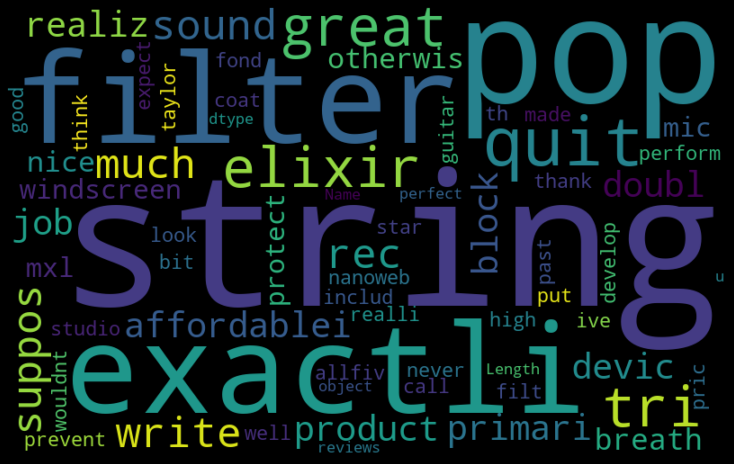

In [67]:

from wordcloud import WordCloud,STOPWORDS
text = review_pos["reviews"]
wordcloud = WordCloud(width = 800,height = 500,background_color = 'black',stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(figsize = (10, 7),facecolor = 'k',edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

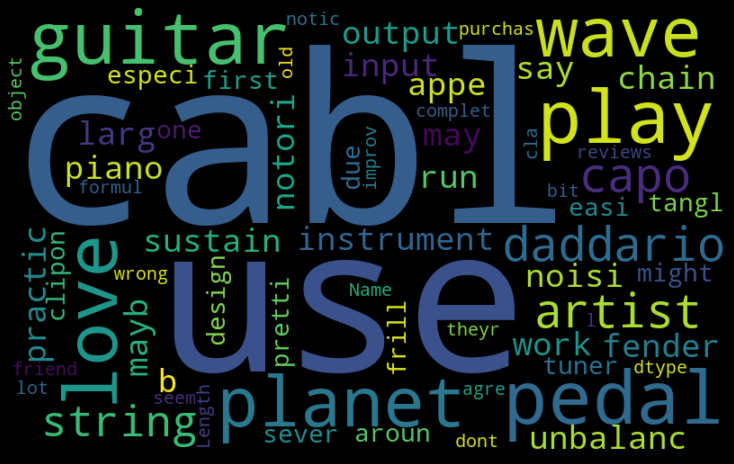

In [68]:
text = review_neu["reviews"]
wordcloud = WordCloud(width = 800,height = 500,background_color = 'black',stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(figsize = (10, 37),facecolor = 'k',edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

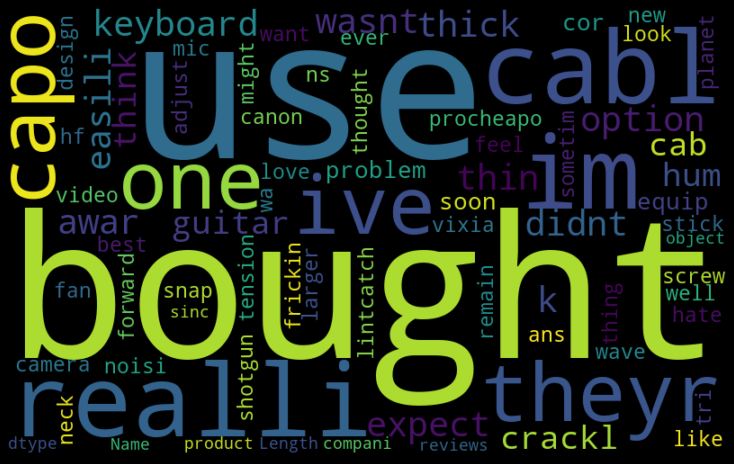

In [69]:
text = review_neg["reviews"]
wordcloud = WordCloud(width = 800,height = 500,background_color = 'black',stopwords = stop_words).generate(str(text))
fig = plt.figure(figsize = (10, 7),facecolor = 'k',edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

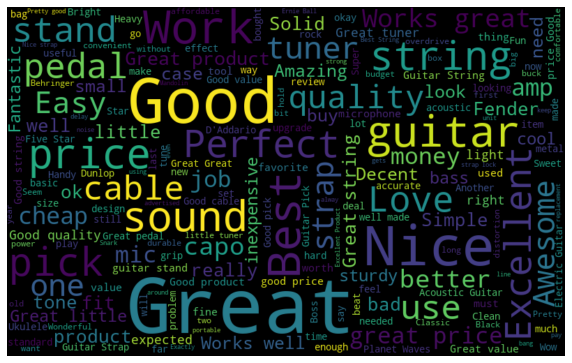

In [70]:
# Create a word cloud
all_words = ' '.join([text for text in data['summary']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [71]:

from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 
# 'sentiment' encoded. 
process_reviews['sentiment']= label_encoder.fit_transform(process_reviews['sentiment']) 
process_reviews['sentiment'].unique() 

array([2, 1, 0])

In [72]:
review_features=process_reviews.copy()
review_features=review_features[['reviews']].reset_index(drop=True)
review_features.head()

,reviews
0,much write exactli suppos filter pop sound rec...
1,product exactli quit affordablei realiz doubl ...
2,primari job devic block breath would otherwis ...
3,nice windscreen protect mxl mic prevent pop th...
4,pop filter great look perform like studio filt...


In [73]:
# it used for  process of removing the commoner morphological and inflexional endings from words in English
# part of a term normalisation process
ps = PorterStemmer()
c = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['reviews'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    c.append(review) 
c[3]

'nice windscreen protect mxl mic prevent pop thing gooseneck margin abl hold screen posit requir care posit clamp avoid sagginggood windscreen money'

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
# This is a technique to quantify a word in documents, we generally compute a weight to each word which signifies the importance of the word in the document and corpus.
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
X= tfidf_vectorizer.fit_transform(review_features['reviews'])
y=process_reviews['sentiment']

In [75]:
from collections import Counter
from imblearn.over_sampling import SMOTE
#since there were more positive ratio then negative and neutral so we used smote to balance the ratio
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print(f'New Dataset shape {Counter(y_res)}')

New Dataset shape Counter({2: 9022, 1: 9022, 0: 9022})


In [76]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)

In [80]:
#MODEL BUILDING SENTIMENT ANALYSIS AFTER SMOTE BALANCED THE DATA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB 
reg_cv = LogisticRegression(random_state=0)
decision_t_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
Svc_cv=SVC()
bernolli_cv=BernoulliNB()
dict_all = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'SVC',4:'Naive Bayes'}
cv_models=[reg_cv,decision_t_cv,knn_cv,Svc_cv,bernolli_cv]


for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(dict_all[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.8801286321939219
Decision Tree Test Accuracy: 0.8083032014744207
KNN Test Accuracy: 0.852840841148636
SVC Test Accuracy: 0.8798361396296107
Naive Bayes Test Accuracy: 0.8035264239794554


In [81]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
# Train a SVM model
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(kernel='linear')

In [84]:
# Perform hyperparameter tuning
from sklearn import svm
parameters = {'C': [1, 10, 100], 'gamma': [0.1, 0.01, 0.001]}
grid_search = GridSearchCV(svm.SVC(), parameters, scoring='f1_weighted', cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10, 100], 'gamma': [0.1, 0.01, 0.001]},
             scoring='f1_weighted')

In [85]:
print('Best parameters:', grid_search.best_params_)

Best parameters: {'C': 100, 'gamma': 0.01}


In [87]:
# Evaluate the model using cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y, cv=kfold, scoring='f1_weighted')
print('Cross-validation scores:', scores)
print('Average cross-validation score:', scores.mean())

Cross-validation scores: [0.82925212 0.82956483 0.82894141 0.79740902 0.84590091 0.81121001
 0.84497805 0.8127741  0.83109393 0.83557956]
Average cross-validation score: 0.8266703938930897


In [88]:
# Evaluate the model on the test set
y_pred = clf.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

In [89]:
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Precision: 0.8051669812469556
Recall: 0.8816366293229421
F1 score: 0.8279731527283029


In [90]:
from sklearn.metrics import classification_report
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       104
           1       0.40      0.01      0.03       140
           2       0.88      1.00      0.94      1809

    accuracy                           0.88      2053
   macro avg       0.43      0.34      0.32      2053
weighted avg       0.81      0.88      0.83      2053



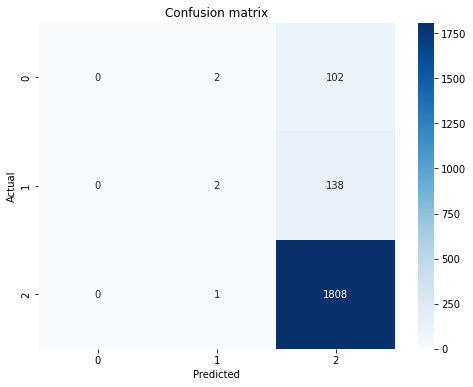

In [91]:
# Visualize the confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()